In [1]:
#import modules
import numpy as np
import pandas as pd
import time
import math
from keras import backend as K 
from keras.engine.training import Model
from tensorflow.keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout, Activation, Flatten
from keras.layers import LSTM, Dense, Input
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
import shap
import tensorflow as tf
tf.GraphKeys.VARIABLES = tf.GraphKeys.GLOBAL_VARIABLES

Using TensorFlow backend.


In [79]:
#reading CSV data
#df = pd.read_csv('C:/Users/Rohini/Desktop/Desktop/HEC_WAT_Emulation/HMS/Training_Testing/Sub_0.csv')
new_df = pd.read_csv('C:/Users/Rohini/Documents/Sub0.csv')
df.head()

,Group.1,Year,Month,Day,Hours,Precipitation,Temperature,Outflow,sin_day,Three_Day_Flow,Two_Week_Flow,Month_Flow,Season_Flow,Precip_Times_Temperature,Temperature_Times_Day,Precip_Times_Temperature_Times_Day,cos_day,Date
0,10/1/1980,1980,10,1,0.48,0.0,86.76650,4.750000,0.841471,0.0,0.0,0.0,0,0.0,73.011492,0.0,0.540302,10/1/1980
1,10/2/1980,1980,10,2,0.48,0.0,88.84100,4.000000,0.909297,0.0,0.0,0.0,0,0.0,80.782893,0.0,-0.416147,10/2/1980
2,10/3/1980,1980,10,3,0.48,0.0,88.21025,4.000000,0.141120,0.0,0.0,0.0,0,0.0,12.448231,0.0,-0.989992,10/3/1980
3,10/4/1980,1980,10,4,0.48,0.0,88.27475,3.833333,-0.756802,0.0,0.0,0.0,0,0.0,-66.806551,0.0,-0.653644,10/4/1980
4,10/5/1980,1980,10,5,0.48,0.0,81.97175,3.000000,-0.958924,0.0,0.0,0.0,0,0.0,-78.604701,0.0,0.283662,10/5/1980


In [80]:
#define train and label column
train_cols = ["Precipitation","Temperature","sin_day","Three_Day_Flow","Two_Week_Flow","Precip_Times_Temperature","Temperature_Times_Day","Precip_Times_Temperature_Times_Day"]
label_cols = ["Outflow"]

In [81]:
#instantiating different Min Max scalar Normalization for trainning and testing data
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [82]:
#function to shift the time_series data for getting labels
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df=df
    return df

# building timeseries data with given timesteps
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

#getting data ready for training the model
def data_processing(lag_df):
    #Splitting training and test data
    df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
    x_train = df_train.loc[:,train_cols].values
    y_train = df_train.loc[:,label_cols].values
    x_test = df_test.loc[:,train_cols].values
    y_test = df_test.loc[:,label_cols].values    
   
    #Normalizing training data
    x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
    y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

    # Normalizing test data
    x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
    y_test_nor = ytest_min_max_scaler.fit_transform(y_test)
    
    # Saving actual train and test y_label to calculate mean square error later after training
    y_train_actual = y_train
    y_test_actual = y_test
    
    #Building timeseries
    X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=30, out_steps=1)
    X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=30, out_steps=1)
    
    return X_Train, Y_Train, Y_train_actual, X_Test, Y_Test, Y_test_actual

In [83]:
#calling function to create lag dataframe
lag_df = lag_seq(new_df, 0)
lag_df.dropna(inplace=True)
X_Train, Y_Train, Y_train_actual, X_Test, Y_Test, Y_test_actual = data_processing(lag_df)


length of time-series i/o (6138, 30, 8) (6138,)



length of time-series i/o (1512, 30, 8) (1512,)


In [84]:
#Splitting X_Train and Y_Train into validation and Training data
len_train = math.floor(0.9*len(X_Train))
len_valid = len(X_Train)
X_Val, Y_Val = X_Train[len_train:len_valid], Y_Train[len_train:len_valid]
X_Trn, Y_Trn = X_Train[:len_train], Y_Train[:len_train]

In [85]:
#Build Model
def make_model(X_Train):
    input_layer = Input(shape=(X_Train.shape[1], X_Train.shape[2]))

    lstm1 = LSTM(units=16, return_sequences=True)(input_layer)
    dropout1 = Dropout(0.2)(lstm1)
    lstm2 = LSTM(units=32, return_sequences=True)(dropout1)
    dropout2 = Dropout(0.2)(lstm2)
    lstm3 = LSTM(units=64)(dropout2)
    dropout3 = Dropout(0.2)(lstm3)

    dense1 = Dense(128, activation='relu')(dropout3)
    dense2 = Dense(64, activation='relu')(dense1)
    output_layer = Dense(1, activation='linear')(dense2)
    
    return Model(inputs=input_layer, outputs=output_layer)


In [86]:
#lists to save different parameters while training
mse_for_iter = []
train_loss_over_epoch = []
val_loss_over_epoch = []
predicted_y_values_unnors = []
models = []
#function to iterate training
def run_iteration(no_iter=1, epochs = 10):      
    start_time = time.time()
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()                        #clears sesssion after every training iteration to record new MSE
        model = make_model(X_Train)
        #plot_model(model, show_shapes=True)
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        history = model.fit(X_Trn, Y_Trn, epochs=epochs,
                       validation_data=(X_Val, Y_Val))
        train_loss_over_epoch.append(history.history['loss'])
        val_loss_over_epoch.append(history.history['val_loss'])
        predicted_y_values = model.predict(X_Test)
        predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)
        mse_for_iter.append(mean_squared_error(predicted_y_values_unnor, Y_test_actual))
        predicted_y_values_unnors.append(predicted_y_values_unnor)
        models.append(model)
        
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return predicted_y_values_unnor, model

predicted_y_values_unnor, model = run_iteration(1,10)

Iteration: 1
Train on 5524 samples, validate on 614 samples
Epoch 1/10
5524/5524 [==============================] - ETA: 38:41 - loss: 0.00 - ETA: 19:22 - loss: 0.00 - ETA: 12:56 - loss: 0.00 - ETA: 9:55 - loss: 0.0018 - ETA: 7:57 - loss: 0.001 - ETA: 6:37 - loss: 0.002 - ETA: 6:11 - loss: 0.002 - ETA: 5:38 - loss: 0.001 - ETA: 5:03 - loss: 0.001 - ETA: 4:33 - loss: 0.001 - ETA: 4:10 - loss: 0.001 - ETA: 3:51 - loss: 0.001 - ETA: 3:35 - loss: 0.001 - ETA: 3:20 - loss: 0.001 - ETA: 3:07 - loss: 0.001 - ETA: 2:55 - loss: 0.001 - ETA: 2:44 - loss: 0.001 - ETA: 2:36 - loss: 0.001 - ETA: 2:29 - loss: 0.001 - ETA: 2:21 - loss: 0.002 - ETA: 2:14 - loss: 0.002 - ETA: 2:08 - loss: 0.002 - ETA: 2:02 - loss: 0.002 - ETA: 1:57 - loss: 0.002 - ETA: 1:52 - loss: 0.002 - ETA: 1:49 - loss: 0.002 - ETA: 1:46 - loss: 0.002 - ETA: 1:43 - loss: 0.002 - ETA: 1:39 - loss: 0.003 - ETA: 1:36 - loss: 0.002 - ETA: 1:33 - loss: 0.002 - ETA: 1:31 - loss: 0.002 - ETA: 1:28 - loss: 0.002 - ETA: 1:26 - loss: 0.003 -

5524/5524 [==============================] - ETA: 14s - loss: 5.5700e- - ETA: 15s - loss: 4.4693e- - ETA: 17s - loss: 4.8607e- - ETA: 16s - loss: 4.8556e- - ETA: 16s - loss: 5.2570e- - ETA: 15s - loss: 6.8509e- - ETA: 15s - loss: 0.0029   - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss

5524/5524 [==============================] - ETA: 20s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 17s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 15s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.

5524/5524 [==============================] - ETA: 10s - loss: 4.3047e- - ETA: 10s - loss: 5.2404e- - ETA: 10s - loss: 4.3133e- - ETA: 10s - loss: 7.1776e- - ETA: 10s - loss: 9.9296e- - ETA: 10s - loss: 8.6954e- - ETA: 11s - loss: 8.7815e- - ETA: 11s - loss: 8.7444e- - ETA: 11s - loss: 0.0013   - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10

5524/5524 [==============================] - ETA: 10s - loss: 5.3269e- - ETA: 10s - loss: 7.4852e- - ETA: 11s - loss: 9.1965e- - ETA: 11s - loss: 0.0028   - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 9s - loss: 0.0012 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 9.8299e-0 - ETA: 9s - loss: 9.5190e-0 - ETA: 9s - loss: 9.2180e-0 - ETA: 9s - loss: 0.0010    - ETA: 9s - loss: 9.9763e-0 - ETA: 9s - loss: 0.0010    - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 9s - loss: 0.001 - ETA: 8s - loss: 0.001 - ETA: 9s - loss: 0.001 - ET

5524/5524 [==============================] - ETA: 10s - loss: 0.00 - ETA: 10s - loss: 8.6630e- - ETA: 10s - loss: 6.5230e- - ETA: 10s - loss: 4.9508e- - ETA: 11s - loss: 5.0457e- - ETA: 11s - loss: 4.3484e- - ETA: 12s - loss: 3.7675e- - ETA: 11s - loss: 4.3306e- - ETA: 12s - loss: 5.2270e- - ETA: 12s - loss: 4.8014e- - ETA: 12s - loss: 4.9697e- - ETA: 12s - loss: 4.6238e- - ETA: 12s - loss: 4.6566e- - ETA: 12s - loss: 4.5181e- - ETA: 12s - loss: 5.5144e- - ETA: 12s - loss: 5.4483e- - ETA: 12s - loss: 5.3364e- - ETA: 11s - loss: 5.2051e- - ETA: 12s - loss: 5.4309e- - ETA: 12s - loss: 5.5902e- - ETA: 12s - loss: 6.1022e- - ETA: 12s - loss: 6.3960e- - ETA: 12s - loss: 6.9733e- - ETA: 12s - loss: 7.3785e- - ETA: 12s - loss: 7.1504e- - ETA: 11s - loss: 6.9715e- - ETA: 11s - loss: 7.1446e- - ETA: 11s - loss: 7.0808e- - ETA: 11s - loss: 7.9626e- - ETA: 12s - loss: 7.7347e- - ETA: 12s - loss: 8.0898e- - ETA: 12s - loss: 7.9056e- - ETA: 12s - loss: 7.6831e- - ETA: 11s - loss: 7.5866e- - ETA: 11

5524/5524 [==============================] - ETA: 13s - loss: 4.9828e- - ETA: 15s - loss: 2.7339e- - ETA: 16s - loss: 2.3869e- - ETA: 16s - loss: 1.9446e- - ETA: 15s - loss: 1.8144e- - ETA: 14s - loss: 1.9262e- - ETA: 14s - loss: 3.4810e- - ETA: 13s - loss: 3.1296e- - ETA: 13s - loss: 3.4386e- - ETA: 13s - loss: 5.0148e- - ETA: 13s - loss: 6.3905e- - ETA: 13s - loss: 5.8684e- - ETA: 12s - loss: 5.4607e- - ETA: 12s - loss: 5.3218e- - ETA: 12s - loss: 5.5552e- - ETA: 12s - loss: 5.8644e- - ETA: 12s - loss: 5.5569e- - ETA: 12s - loss: 5.3317e- - ETA: 12s - loss: 5.3608e- - ETA: 12s - loss: 5.9678e- - ETA: 11s - loss: 7.2377e- - ETA: 11s - loss: 7.3590e- - ETA: 11s - loss: 7.3304e- - ETA: 11s - loss: 7.0999e- - ETA: 11s - loss: 6.8856e- - ETA: 11s - loss: 6.6828e- - ETA: 11s - loss: 6.7749e- - ETA: 10s - loss: 6.5951e- - ETA: 10s - loss: 6.6338e- - ETA: 10s - loss: 6.4242e- - ETA: 10s - loss: 6.3130e- - ETA: 10s - loss: 6.2270e- - ETA: 10s - loss: 6.0976e- - ETA: 10s - loss: 5.9805e- - ETA

5524/5524 [==============================] - ETA: 11s - loss: 3.5118e- - ETA: 10s - loss: 7.3706e- - ETA: 11s - loss: 5.5753e- - ETA: 11s - loss: 2.4792e- - ETA: 13s - loss: 2.3227e- - ETA: 13s - loss: 2.1562e- - ETA: 13s - loss: 4.1551e- - ETA: 13s - loss: 4.7152e- - ETA: 12s - loss: 4.9565e- - ETA: 12s - loss: 6.3157e- - ETA: 12s - loss: 6.0082e- - ETA: 12s - loss: 5.7001e- - ETA: 12s - loss: 5.6638e- - ETA: 12s - loss: 5.6149e- - ETA: 13s - loss: 7.9579e- - ETA: 14s - loss: 7.5754e- - ETA: 14s - loss: 7.2225e- - ETA: 14s - loss: 6.8862e- - ETA: 14s - loss: 9.6110e- - ETA: 13s - loss: 9.5028e- - ETA: 13s - loss: 9.1686e- - ETA: 13s - loss: 9.0885e- - ETA: 13s - loss: 9.9225e- - ETA: 13s - loss: 0.0010   - ETA: 13s - loss: 0.00 - ETA: 13s - loss: 0.00 - ETA: 12s - loss: 9.9022e- - ETA: 12s - loss: 0.0012   - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 11s - 

In [15]:
#Saving the trained model
model.save("lstm_model1_all_features.hdf5")

In [12]:
model = load_model('lstm_model1_all_features.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


# Function to visualize
1. Mean Square Error over different training iterations
2. Training and validation loss over epochs for each iterations
3. Actual vs. predicted values plot

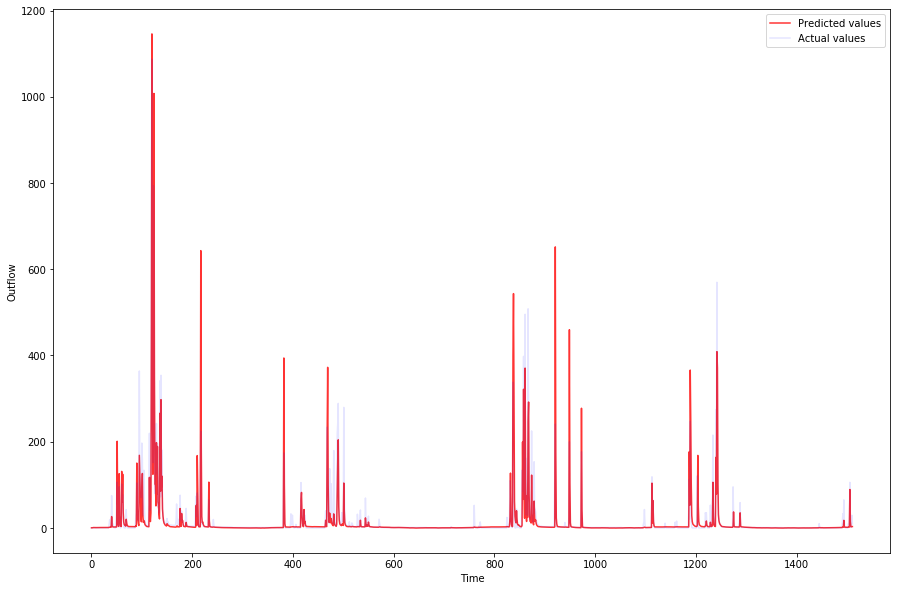

In [90]:
#Function to visualize:
def plot_evaluation():
    #mean square error over iterations
    #plot predicted value vs actual values from last iteration
    plt.figure(figsize=(15, 10))
    plt.plot(predicted_y_values_unnor, 'r', alpha=0.8)
    plt.plot(Y_test_actual, 'b', alpha=0.1)
    plt.legend(['Predicted values', 'Actual values'], loc='upper right')
    plt.ylabel('Outflow')
    plt.xlabel('Time')
    plt.savefig('prediction.png', bbox_inches='tight')
    plt.show()
    
#call plot_evaluation function
plot_evaluation()

In [89]:
# Mean MSE over all iterations
print(np.mean(mse_for_iter))

1467.0521916459302


In [92]:
#Deep Shap Implementation (Training)
random_ind = np.random.choice(X_Train.shape[0], 1000, replace=False)
data = X_Train[random_ind[0:500]]
e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output),data,K.get_session())
#Deep Shap Testing
test1 = X_Train[random_ind[500:1000]]
shap_values = e.shap_values(test1)
shap_val = np.array(shap_values)
shap_val = np.reshape(shap_val,(int(shap_val.shape[1]),int(shap_val.shape[2]),int(shap_val.shape[3])))
shap_abs = np.absolute(shap_val)
sum_0 = np.mean(shap_abs,axis=0)

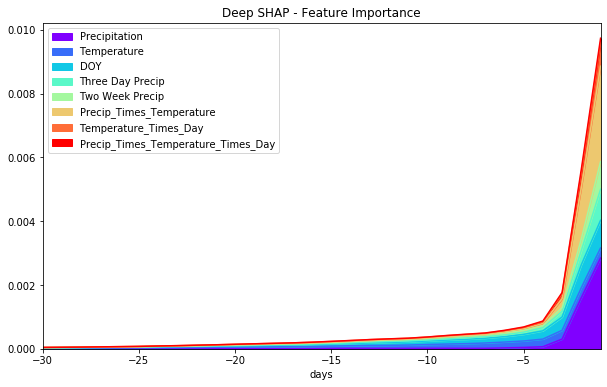

In [94]:
shap_plot = pd.DataFrame(sum_0, columns=["Precipitation","Temperature","DOY","Three Day Precip","Two Week Precip","Precip_Times_Temperature","Temperature_Times_Day","Precip_Times_Temperature_Times_Day"])
shap_plot['days'] = [i-31 for i in list(range(1,31))]
shap_plot.head()
shap_plot.plot.area(x='days',figsize=(10, 6), cmap='rainbow')
plt.title("Deep SHAP - Feature Importance")
plt.savefig('SHAP.png', bbox_inches='tight')
plt.show()

In [96]:
shap.initjs()
features=["Precipitation","Temperature","DOY","Three Day Precip","Two Week Precip","Precip_Times_Temperature","Temperature_Times_Day","Precip_Times_Temperature_Times_Day"]
#features=["Precipitation","Temperature","DOY","Precip_Times_Temperature","Temperature_Times_Day","Precip_Times_Temperature_Times_Day"]
shap.force_plot(e.expected_value[0],shap_values[0][:,0,:],features=features)

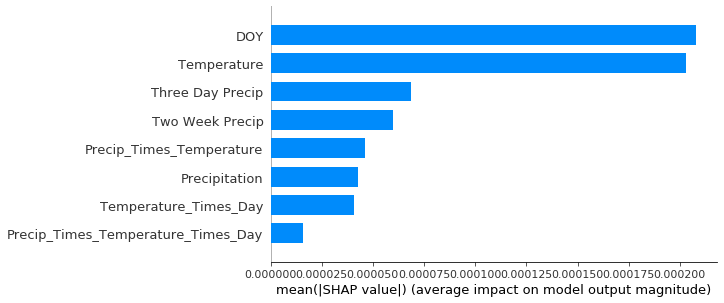

In [97]:
#np.shape(shap_values[0])
shap.summary_plot(shap_values[0][:,25, :], feature_names=features, plot_type="bar")

In [48]:
shap.force_plot(e.expected_value[0], shap_values[0][:, 0, :], test1[:, 0, :])